## Install Library

In [ ]:
!pip install sastrawi gensim tensorflow

## Import Library

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 42
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

import csv
import requests
from io import StringIO

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Load Dataset

In [ ]:
# Membaca dataset ulasan aplikasi Blibli dari file CSV
df = pd.read_csv('ulasan_aplikasi_blibli.csv', engine='python', on_bad_lines='skip')

# Menampilkan jumlah baris dan kolom dataset
df.shape

(130712, 11)

In [ ]:
# Menampilkan 5 data teratas untuk melihat struktur dan isi awal dataset
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,3769931c-97ca-4213-8133-70b7ca8f4f0d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat kecewa..Pengiriman expedisi nya lebih b...,1,24,13.0.0,2025-12-07 15:43:46,Halo kak Nasrul mohon maaf atas pengalaman bel...,2025-12-07 21:05:07,13.0.0
1,4de8df7c-ac86-47fd-8a3c-a04e54a93294,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Selalu gratis ongkir kapanpun. Menu pencarian ...,4,31,12.9.5,2025-11-19 17:23:07,Halo kak Al Ayyubi mohon maaf terkait pengalam...,2025-11-19 22:13:41,12.9.5
2,08787532-7227-4405-a238-cc39b510cf74,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"di Kabupaten Mandailing Natal, Kecamatan Ulupu...",1,7,13.1.0,2025-12-29 12:16:26,Halo kakak mohon maaf terkait pengalaman yang ...,2025-12-30 18:13:15,13.1.0
3,0c8c455d-4886-4d8f-a771-dcf3bfe43900,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya retur barang ditolak krna tdk ada tanggap...,1,23,13.0.0,2025-12-02 22:01:14,Halo kak Muhamad Fadli mohon maaf terkait pros...,2025-12-02 22:10:03,13.0.0
4,c091c10d-d12a-4e97-9e7a-5293cd157791,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Belanja aman nyaman hanya di Blibli,, tetapi p...",3,4,13.0.0,2025-12-26 09:30:59,Halo kak! mohon maaf terkait proses transaksi ...,2025-12-29 04:20:17,13.0.0


In [ ]:
# Menampilkan informasi dataset:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130712 entries, 0 to 130711
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              130712 non-null  object
 1   userName              130712 non-null  object
 2   userImage             130712 non-null  object
 3   content               130695 non-null  object
 4   score                 130712 non-null  int64 
 5   thumbsUpCount         130712 non-null  int64 
 6   reviewCreatedVersion  92333 non-null   object
 7   at                    130712 non-null  object
 8   replyContent          130691 non-null  object
 9   repliedAt             130691 non-null  object
 10  appVersion            92333 non-null   object
dtypes: int64(2), object(9)
memory usage: 11.0+ MB


In [ ]:
# Menghapus data yang memiliki nilai kosong (NaN)
clean_df = df.dropna()

# Menghapus data duplikat agar tidak bias saat training
clean_df = clean_df.drop_duplicates()

# Mengambil jumlah ulasan dan jumlah kolom setelah cleaning
jumlah_ulasan, jumlah_kolom = clean_df.shape

# Menampilkan jumlah data setelah proses cleaning
print(f"Data setelah cleaning: {jumlah_ulasan}")


Data setelah cleaning: 92309


## Preprocessing Data

In [ ]:
# Fungsi pembersihan data
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

# Fungsi Casefolding
def casefoldingText(text):
    text = text.lower()
    return text

# Fungsi Tokenizing
def tokenizingText(text):
    text = word_tokenize(text)
    return text

# Menghapus stopwords dalam teks
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# Fungsi to Sentence
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "gk": "tidak", "ga": "tidak"}

# Menghapus kumpulan kata informal
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
    fixed_text = ' '.join(fixed_words)
    return fixed_text


In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

clean_df[['content', 'text_akhir']].head()

,content,text_akhir
0,Sangat kecewa..Pengiriman expedisi nya lebih b...,kecewapengiriman expedisi buruk toko hijau kes...
1,Selalu gratis ongkir kapanpun. Menu pencarian ...,gratis ongkir menu pencarian mudah gambarnya u...
2,"di Kabupaten Mandailing Natal, Kecamatan Ulupu...",kabupaten mandailing natal kecamatan ulupungku...
3,saya retur barang ditolak krna tdk ada tanggap...,retur barang ditolak krna tdk tanggapan gimana...
4,"Belanja aman nyaman hanya di Blibli,, tetapi p...",belanja aman nyaman blibli proses pengiriman l...


## Pelabelan

In [ ]:
# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response.status_code == 200:
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
        lexicon_positive[row[0]] = int(row[1])

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub
response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
        lexicon_negative[row[0]] = int(row[1])


In [ ]:
# Fungsi untuk menentukan polaritas sentimen dari tweet
def sentiment_analysis_lexicon_indonesia(text):

    # Inisialisasi skor sentimen ke 0
    score = 0

    # Mengulangi setiap kata dalam teks
    for word in text:
        # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
        # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    # Inisialisasi variabel polaritas
    polarity=''

    # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    if (score > 0):
        polarity = 'positive'

    # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif
    elif (score < 0):
        polarity = 'negative'

    # Ini adalah bagian yang bisa digunakan untuk menentukan polaritas netral jika diperlukan
    else:
        polarity = 'neutral'

    # Mengembalikan skor sentimen dan polaritas teks
    return score, polarity

# Menentukan skor prioritas sentimen
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    45396
neutral     25203
negative    21710
Name: count, dtype: int64


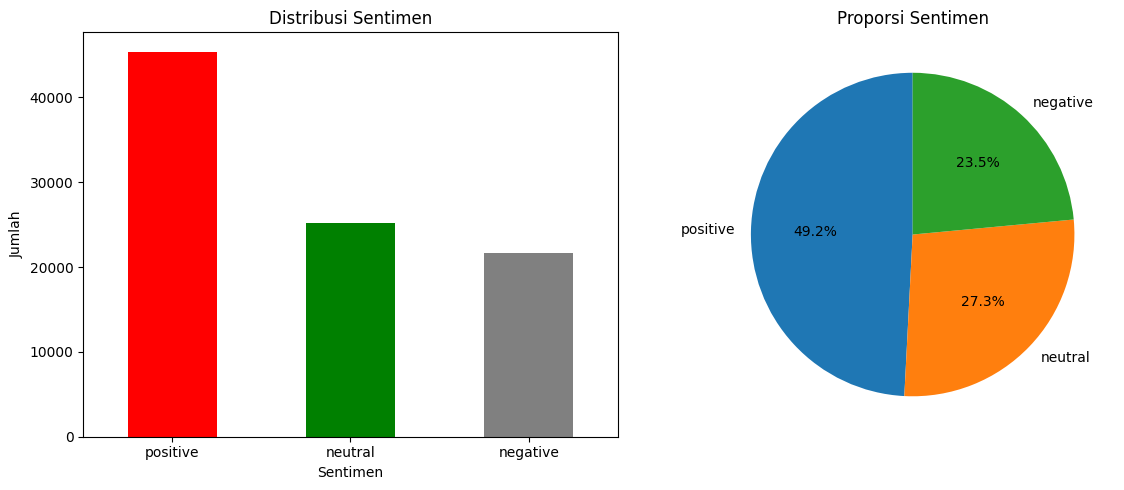

In [ ]:
# Visualisasi
sentiment_counts = clean_df['polarity'].value_counts()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sentiment_counts.plot(kind='bar', color=['red', 'green', 'gray'])
plt.title('Distribusi Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Proporsi Sentimen')

plt.tight_layout()
plt.show()

## Eksplorasi Label

In [ ]:
# Jika perlu, tambahkan stopwords bahasa Indonesia dari NLTK atau daftar custom
try:
    from nltk.corpus import stopwords as nltk_stop
    ind_stop = set(nltk_stop.words('indonesian'))
except Exception:
    ind_stop = set()

# Tambahkan stopwords custom yang sudah kamu pakai
custom_stop = set(['rt','amp','jang','klo','gk','ga','yg','nya','juga', 'udah', 'oke', 'aja', 'yang', 'ok', 'buka', 'beli', 'pake', 'banget'])
all_stopwords = STOPWORDS.union(ind_stop).union(custom_stop)

# Fungsi bantu — buat string besar dari kolom text
def join_texts(series):
    # Jika elemen berupa list token atau string, tangani keduanya
    texts = []
    for v in series.dropna():
        if isinstance(v, (list, tuple)):
            texts.append(' '.join(v))
        else:
            texts.append(str(v))
    return ' '.join(texts)

# 1. Teks keseluruhan
text_all = join_texts(clean_df['text_akhir'])

# 2. Teks positive
text_pos = join_texts(clean_df.loc[clean_df['polarity']=='positive', 'text_akhir'])

# 3. Teks negative
text_neg = join_texts(clean_df.loc[clean_df['polarity']=='negative', 'text_akhir'])


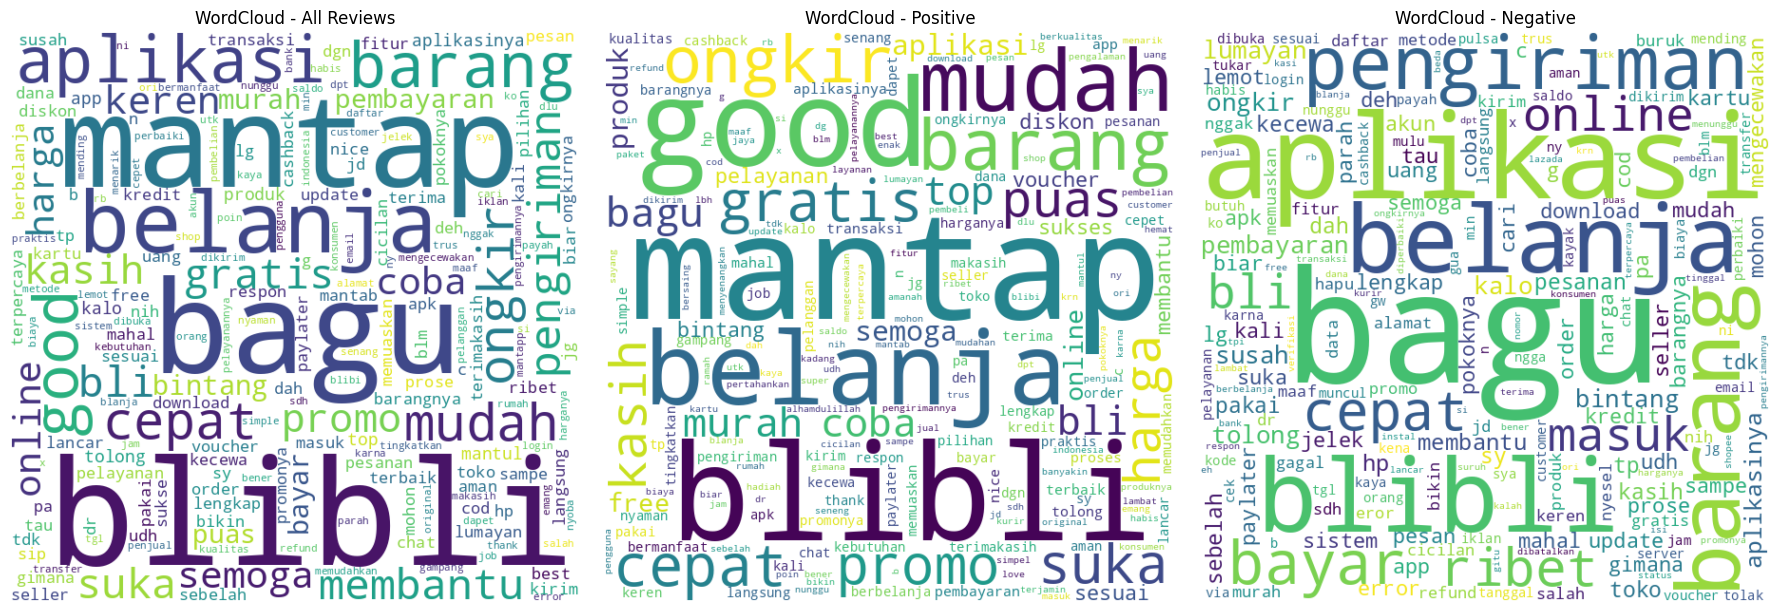

In [ ]:
# Tampilkan wordcloud
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
wc_all = WordCloud(background_color='white', width=600, height=600, stopwords=all_stopwords, max_words=200, collocations=False).generate(text_all)
plt.imshow(wc_all, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - All Reviews')

plt.subplot(1,3,2)
wc_pos = WordCloud(background_color='white', width=600, height=600, stopwords=all_stopwords, max_words=200, collocations=False).generate(text_pos)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Positive')

plt.subplot(1,3,3)
wc_neg = WordCloud(background_color='white', width=600, height=600, stopwords=all_stopwords, max_words=200, collocations=False).generate(text_neg)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Negative')

plt.tight_layout()
plt.show()

In [ ]:
X = clean_df['text_akhir']
y = clean_df['polarity']

print(f"Total data: {len(X)}")
print(f"Distribusi kelas:\n{y.value_counts()}")

Total data: 92309
Distribusi kelas:
polarity
positive    45396
neutral     25203
negative    21710
Name: count, dtype: int64


## Ekstraksi Fitur TF-IDF, Data Spliting, dan Modeling Logistic Regression

Accuracy Train: 95.75%
Accuracy Test: 94.64%

Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.92      0.92      4342
     neutral       0.92      0.94      0.93      5041
    positive       0.97      0.97      0.97      9079

    accuracy                           0.95     18462
   macro avg       0.94      0.94      0.94     18462
weighted avg       0.95      0.95      0.95     18462



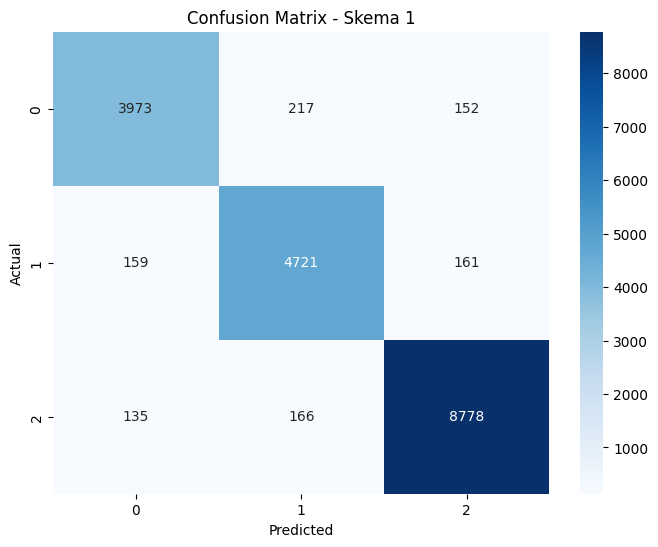

In [ ]:
# Import Library
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Ekstraksi TF-IDF
tfidf = TfidfVectorizer(max_features=5000, min_df=3, max_df=0.8, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

# Data Spliting
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_tfidf, y, test_size=0.2, random_state=seed, stratify=y)

# Melatih model Logistic Regression pada data pelatihan
lr_model = LogisticRegression(max_iter=1000, random_state=seed)
lr_model.fit(X_train_1, y_train_1)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_1 = lr_model.predict(X_train_1)
y_pred_test_1 = lr_model.predict(X_test_1)

# Evaluasi akurasi model Logistic Regression pada data pelatihan
acc_train_1 = accuracy_score(y_train_1, y_pred_train_1)

# Evaluasi akurasi model Logistic Regression pada data uji
acc_test_1 = accuracy_score(y_test_1, y_pred_test_1)

# Menampilkan akurasi
print(f'Accuracy Train: {acc_train_1*100:.2f}%')
print(f'Accuracy Test: {acc_test_1*100:.2f}%')
print('\nClassification Report:')
print(classification_report(y_test_1, y_pred_test_1))

# Visualisasi LR
cm_1 = confusion_matrix(y_test_1, y_pred_test_1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Skema 1')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Representasi Teks Berbasis Embedding dan Pemodelan LSTM

Label mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}
Class weight: {0: np.float64(1.4173000153539075), 1: np.float64(1.2208940911946566), 2: np.float64(0.6778001119769438)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 46s 23ms/step - accuracy: 0.8029 - loss: 0.4522 - val_accuracy: 0.9431 - val_loss: 0.1564
Epoch 2/25
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9624 - loss: 0.1233 - val_accuracy: 0.9494 - val_loss: 0.1440
Epoch 3/25
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9698 - loss: 0.0960 - val_accuracy: 0.9608 - val_loss: 0.1278
Epoch 4/25
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9767 - loss: 0.0764 - val_accuracy: 0.9622 - val_loss: 0.1199
Epoch 5/25
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9813 - loss: 0.0626 - val_accuracy: 0.9624 - val_loss: 0.1340
Epoch 6/25
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9844 - loss: 0.0526 - val_accuracy: 0.9644 - val_loss: 0.1513
Epoch 7/25
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9863 - loss: 0.0502 - val_accuracy: 0.9608 - val_loss: 0.1595
Epoch 8/25
1847/1847 ━━━━━━━━━━━━━━━━━━━━ 41s 22ms/step - accuracy: 0.9877 -

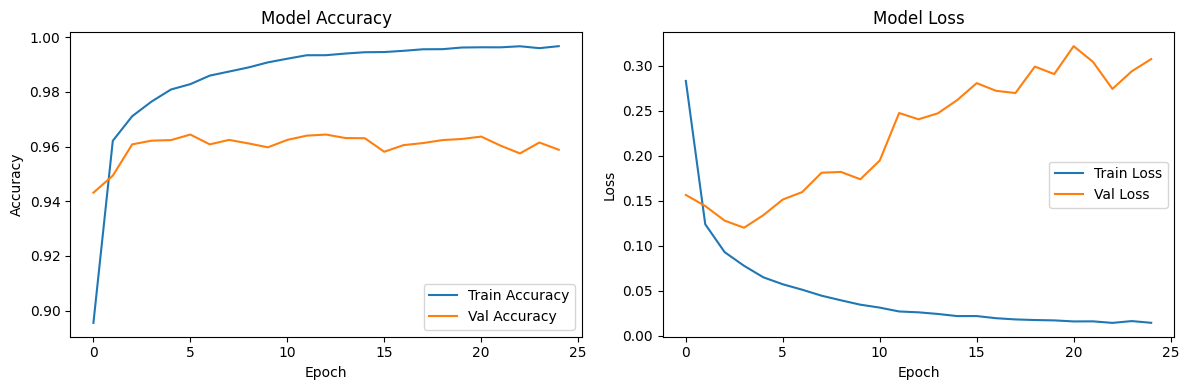

Accuracy Train: 99.00%
Accuracy Test: 96.05%

Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.96      0.95      4342
     neutral       0.94      0.95      0.94      5041
    positive       0.98      0.97      0.97      9079

    accuracy                           0.96     18462
   macro avg       0.95      0.96      0.96     18462
weighted avg       0.96      0.96      0.96     18462



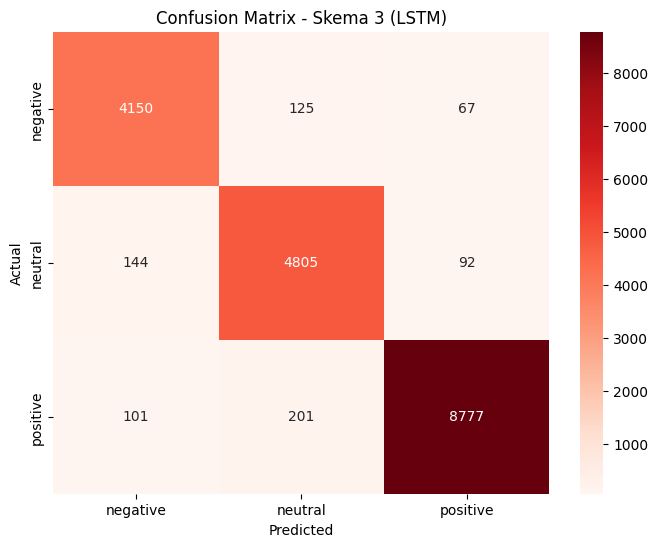

In [ ]:
# Import library deep learning dan preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Jumlah maksimum kata yang dipakai tokenizer
max_words = 5000

# Panjang maksimum sequence input
max_len = 100


# Inisialisasi tokenizer untuk mengubah teks menjadi indeks kata
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')

# Membangun vocabulary berdasarkan data teks
tokenizer.fit_on_texts(X)

# Mengubah teks menjadi sequence angka
X_seq = tokenizer.texts_to_sequences(X)

# Padding sequence agar panjangnya seragam
X_pad = pad_sequences(
    X_seq,
    maxlen=max_len,
    padding='post',
    truncating='post'
)


# Inisialisasi label encoder untuk label target
label_encoder = LabelEncoder()

# Mengubah label target menjadi numerik
y_encoded = label_encoder.fit_transform(y)

print("Label mapping:", dict(enumerate(label_encoder.classes_)))


# Membagi data menjadi data latih dan data uji
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    X_pad,
    y_encoded,
    test_size=0.2,
    random_state=seed,
    stratify=y_encoded
)

# CLASS WEIGHT
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_3),
    y=y_train_3
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weight:", class_weight_dict)


# Membangun arsitektur model LSTM
model_lstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(32)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(len(label_encoder.classes_), activation='softmax')
])

# Konfigurasi model
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()

# TRAINING
history = model_lstm.fit(
    X_train_3,
    y_train_3,
    epochs=25,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    verbose=1
)

# VISUALISASI TRAINING
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# EVALUASI MODEL
train_loss_3, acc_train_3 = model_lstm.evaluate(X_train_3, y_train_3, verbose=0)
test_loss_3, acc_test_3 = model_lstm.evaluate(X_test_3, y_test_3, verbose=0)

print(f'Accuracy Train: {acc_train_3*100:.2f}%')
print(f'Accuracy Test: {acc_test_3*100:.2f}%')


# CLASSIFICATION REPORT
y_pred_test_3_prob = model_lstm.predict(X_test_3, verbose=0)
y_pred_test_3 = np.argmax(y_pred_test_3_prob, axis=1)

print('\nClassification Report:')
print(classification_report(
    y_test_3,
    y_pred_test_3,
    target_names=label_encoder.classes_
))


# CONFUSION MATRIX
cm_3 = confusion_matrix(y_test_3, y_pred_test_3)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_3,
    annot=True,
    fmt='d',
    cmap='Reds',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix - Skema 3 (LSTM)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## Ekstraksi Fitur TF-IDF, Data Spliting, dan Modeling Linear SVC

Accuracy Train SVC: 98.03%
Accuracy Test SVC: 95.64%

Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94      4342
     neutral       0.94      0.94      0.94      5041
    positive       0.97      0.98      0.97      9079

    accuracy                           0.96     18462
   macro avg       0.95      0.95      0.95     18462
weighted avg       0.96      0.96      0.96     18462



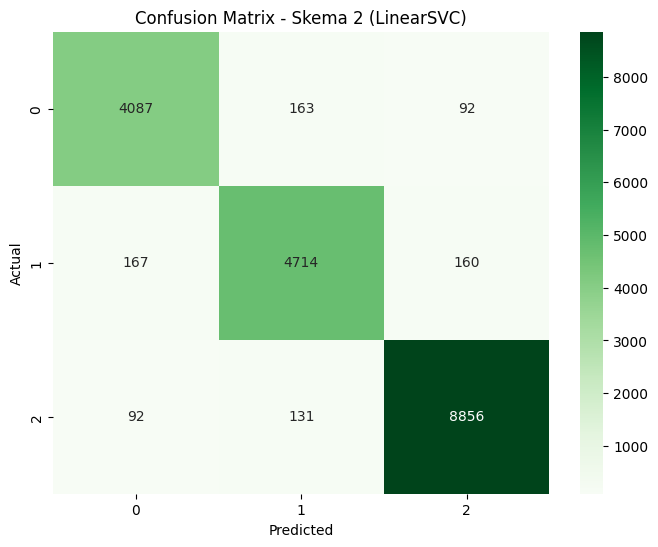

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ekstraksi TF-IDF
tfidf_svc = TfidfVectorizer(max_features=10000, min_df=3, max_df=0.8, ngram_range=(1,2))
X_tfidf_svc = tfidf_svc.fit_transform(X)

# Data Splitting
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_tfidf_svc, y, test_size=0.2, random_state=seed, stratify=y
)

# Modeling LinearSVC
svc_model = LinearSVC(C=1.0, max_iter=2000, random_state=seed, dual=False)
svc_model.fit(X_train_2, y_train_2)

# Prediksi
y_pred_train_2 = svc_model.predict(X_train_2)
y_pred_test_2 = svc_model.predict(X_test_2)

# Evaluasi
acc_train_2 = accuracy_score(y_train_2, y_pred_train_2)
acc_test_2 = accuracy_score(y_test_2, y_pred_test_2)

print(f'Accuracy Train SVC: {acc_train_2*100:.2f}%')
print(f'Accuracy Test SVC: {acc_test_2*100:.2f}%')
print('\nClassification Report:')
print(classification_report(y_test_2, y_pred_test_2))

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_2, y_pred_test_2), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Skema 2 (LinearSVC)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()